# Legolas Outline

Use this code to answer the challenges.

In [2]:
#Not needed if you have already installed GPy and GPyOpt
!pip install GPy
# GPFlow, GPyTorch
!pip install GPyOpt

  Using cached GPy-1.13.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (2.3 kB)
  Using cached paramz-0.9.6-py3-none-any.whl.metadata (1.4 kB)
  Using cached Cython-3.0.10-py2.py3-none-any.whl.metadata (3.2 kB)
Using cached GPy-1.13.1-cp311-cp311-macosx_10_9_universal2.whl (1.9 MB)
Using cached Cython-3.0.10-py2.py3-none-any.whl (1.2 MB)
Using cached paramz-0.9.6-py3-none-any.whl (103 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83644 sha256=3e531df2170f785787c5eb284fcd2f98df1c5d68e6df8076f440199d455d6a32
  Stored in directory: /Users/notaspy/Library/Caches/pip/wheels/b3/5e/fb/38ca2bae62f9d07f22d246c55dd1f4721ac40f82dc6c2f348c
Successfully built GPyOpt


In [2]:
import utils
from core import *

/opt/anaconda3/envs/Legolas_2024/lib/python3.11/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [4]:
# this is how you reset the rpyc server when facing the port already in use
# need to change to actual host name
host_1 = "192.168.1.11"
host_2 = "192.168.1.14"

utils.restart_server(host=host_1)
utils.restart_server(host=host_2)

KeyboardInterrupt: 

In [18]:
stage, depo_device, pH_device, conn1, conn2, config = load_from_config("config.yaml")

In [ ]:
# it is ok if this fails, just move on to the next code block
sanity_check(stage=stage, pH_device=pH_device, depo_device=depo_device)

In [4]:
# find the usb port if problem occur
list_ports = conn1.modules['serial.tools.list_ports']

ports=list_ports.comports()
for port, desc, hwid in sorted(ports):
    print(port, desc, hwid)

/dev/ttyACM0 ttyACM0 USB VID:PID=2341:0043 SER=9553034393435130E032 LOCATION=1-1.3:1.0
/dev/ttyAMA0 ttyAMA0 fe201000.serial


In [5]:
# Go to Home Position
reset(stage=stage, pH_device=pH_device, depo_device=depo_device)
# stage.home()

## (1) Measurement Uncertainty

**(a)** Write a script to create a sample with an equal amount of acid and base (Total volume should be 2 ml and each deposition sequence should not exceed 0.6 mL for LEGOLAS to function properly)

**(b)** Write a script to follow these operations in a loop with 10 measurements:
-  Dip the pH sensor in the DI water well
-  Dip the pH sensor into the sample from (a), measure pH and record.

**(c)** Plot the results from (b). 

What is the mean and variance of these measurements? Please include this information as markdown text in the Jupyter notebook.


In [69]:
stage.home()
pH_device.to_zpos("full_up")
depo_device.to_zpos("full_up")

(795, 377)

In [14]:
def clean():
    pH_device.move_to_loc("clean")
    pH_device.to_zpos("full_down")
    pH_device.to_zpos("full_up")

def blot():
    pH_device.move_to_loc("blot")
    pH_device.to_zpos("full_down")
    time.sleep(1)
    pH_device.to_zpos("full_up")
    
def measure(j,i):
    pH_device.move_to_cell(row=j, col=i)
    pH_device.to_zpos("full_down")
    k = pH_device.pH_measure(30)
    pH_device.to_zpos("full_up")
    return k

def depclean():
    depo_device.move_to_loc("clean")
    depo_device.to_zpos("full_down")
    depo_device.to_zpos("full_up")

def get_row_col(count):
    if count <= 5:
        row = 0
        col = count
    elif count <= 11:
        row = 1
        col = count - 6
    elif count <= 17:
        row = 2
        col = count - 12
    elif count <= 23:
        row = 3
        col = count - 18
    return row, col

voltage is measured as: 1.90
voltage is measured as: 1.25
voltage is measured as: 1.89
voltage is measured as: 1.28
voltage is measured as: 1.89
voltage is measured as: 1.25
slope: 4.731599335915886, intercept: -1.960154952960713


<function matplotlib.pyplot.show(close=None, block=None)>

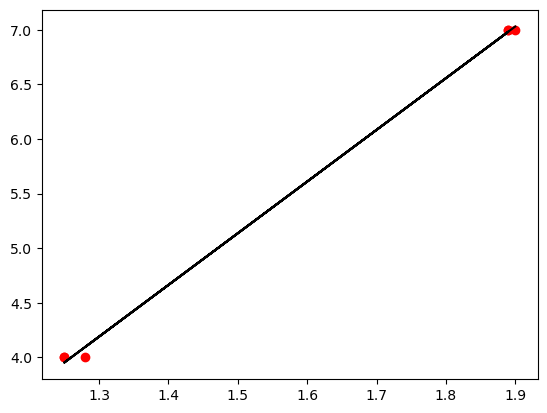

In [37]:
stage.home()

#CALIBRATION WITHOUT CLEANING

y = [7, 4, 7, 4, 7, 4]
x = []

for i in range(6):
    time.sleep(10)
    m7 = pH_device.pH_measure(30)
    x.append(m7)
    stage.home()
        
#PLOTTING FIT

line = np.polyfit(x,y,1)
print(f'slope: {line[0]}, intercept: {line[1]}')
trend = np.poly1d(line)
plt.plot(x,y, 'ro', x, trend(x), '-k')
plt.show

Voltage is Measured as: 1.16
Voltage is Measured as: 1.03
Voltage is Measured as: 1.70
Voltage is Measured as: 1.04
Voltage is Measured as: 1.70
Voltage is Measured as: 1.05
slope: 3.99851906701222, intercept: 0.3818955942243598


<function matplotlib.pyplot.show(close=None, block=None)>

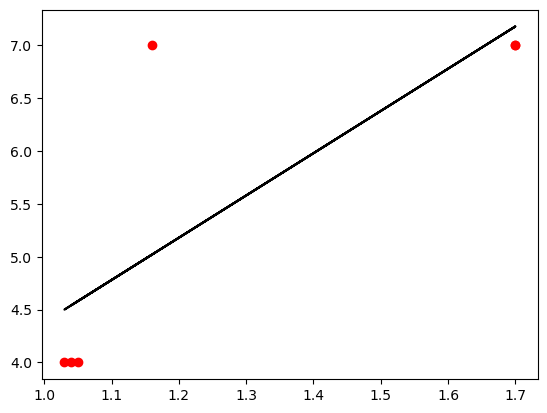

In [19]:
stage.home()

#pH SENSOR CALIBRATION

y = [7, 4, 7, 4, 7, 4]
x = []

for i in range(6):
    clean()
    blot()
    if i % 2 == 0:
        m7 = measure(3,0)
        x.append(m7)
    else:
        m4 = measure(3,1)
        x.append(m4)
        
#PLOTTING FIT

line = np.polyfit(x,y,1)
print(f'slope: {line[0]}, intercept: {line[1]}')
trend = np.poly1d(line)
plt.plot(x,y, 'ro', x, trend(x), '-k')
plt.show
#time.sleep(5)


slope: 4.544063647490824, intercept: -0.725367197062429


<function matplotlib.pyplot.show(close=None, block=None)>

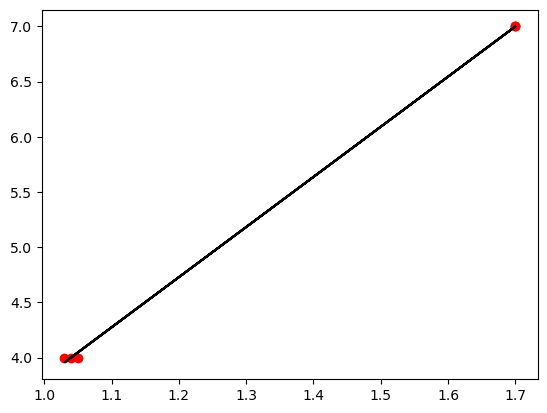

In [20]:
#MANUALLY ADJUSTED DATA PLOTTING

y = [7, 4, 7, 4, 7, 4]
x = [1.7, 1.03, 1.7, 1.04, 1.7, 1.05]

line = np.polyfit(x,y,1)
print(f'slope: {line[0]}, intercept: {line[1]}')
trend = np.poly1d(line)
plt.plot(x,y, 'ro', x, trend(x), '-k')
plt.show

In [11]:
#TESTING PIPETTING

stage.home()                                 #GO HOME BEFORE FIRST ONE
#depclean()

depo_device.acquire(0.3, location="acid")
depo_device.deposition(0.3, row=0, col=0)

depo_device.acquire(0.4, location="acid")
depo_device.deposition(0.4, row=0, col=0)

#depclean()

depo_device.acquire(0.5, location="base")
depo_device.deposition(0.5, row=0, col=0)

depo_device.acquire(0.5, location="base")
depo_device.deposition(0.5, row=0, col=0)

'\n#depclean()\n\ndepo_device.acquire(0.5, location="base")\ndepo_device.deposition(0.5, row=0, col=0)\n\ndepo_device.acquire(0.5, location="base")\ndepo_device.deposition(0.5, row=0, col=0)\n'

In [21]:
#MEASURING pH OF ACID/BASE

m = []

for count in range(8):
    row, col = get_row_col(count)
    clean()
    blot()
    mx = measure(row, col)
    m.append(mx)

'''
for count in range(7, -1, -1):
    row, col = get_row_col(count)
    clean()
    blot()
    mx = measure(row, col)
    m.append(mx)
'''

r = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8]

index = 0
for ratio in r:
    print(f'pH [{ratio}]= {line[0]*m[index]+line[1]}')
    index +=1

Voltage is Measured as: 0.91
Voltage is Measured as: 0.94
Voltage is Measured as: 1.01
Voltage is Measured as: 1.08
Voltage is Measured as: 1.15
Voltage is Measured as: 1.21
Voltage is Measured as: 1.31
Voltage is Measured as: 1.37
pH [0]= 3.4097307221542215
pH [1]= 3.546052631578945
pH [2]= 3.8641370869033036
pH [3]= 4.182221542227661
pH [4]= 4.500305997552018
pH [5]= 4.772949816401468
pH [6]= 5.227356181150551
pH [7]= 5.500000000000001


In [24]:
#REMEASURING STANDARDS FOR COMPARISON

clean()
blot()
m4x = measure(3,1)

print(f'pH 4= {line[0]*m4x+line[1]}')

clean()
blot()
m7x = measure(3,0)

print(f'pH 7= {line[0]*m7x+line[1]}')

Voltage is Measured as: 1.01
pH 4= 3.8641370869033036
Voltage is Measured as: 1.66
pH 7= 6.817778457772339


In [ ]:
#GETTING MEAN AND VARIANCE

measurements = []

#number of trials per well
n=5

for i in range(n):
    clean()
    blot()
    g = line[0]*measure(3, n)+line[1]
    print(f'pH: {g}')
    measurements.append(g)

sum = 0
for x in measurements:
    sum += x

mean = sum/n
print(f'mean = {mean}')

sum = 0
for x in measurements:
    sum += pow(abs(x-mean),2)

variance = sum/(n-1)
print(f'variance = {variance}')

## (2) The Henderson Hasselbach Equation

The HH equation is given as:
$pH = pK - log(\frac{[Acid]}{[Base]})$

The output gives the pH of the sample, pK is a constant, and [Acid] and [Base] are the **concentrations** of acid and base.  For these experiments we will work with the percentage of acid in the sample to create samples varying in composition from a percentage of acid of 10% through 80%.  

**(a)** Write code that will create 8 samples of mixture amounts: acid [10%, 20%, ... 80%]

**(b)** After each sample is made, have the system dip the pH sensor in the DI water well, and then measure the pH of the sample.  Plot the measured pH as a function of the [acid]/[base] **ratio**.  

**(c)** Run the code created during steps (a) and (b) (this should be one for loop accomplishing both tasks together).  Then plot the results.  

**(d)** We will now fit the HH equation to the data.  Write a function that takes in the [acid]/[base] ratio **x** and returns the **pH**, following this equation:
-  Func(x, pK) = pK - log(x), where x = [acid]/[base]

**(e)** Follow the example for the scipy function "curve_fit" to fit this function to the data you have measured: 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

(use default method and no optional parameters)

**(f)** What is the pK value discovered?


In [67]:
def mix(r,j,i):
    a = 2 * r/(r + 1)
    if a <= 0.5:
        b = 0.5 - a
        depo_device.acquire(a, location="acid")
        depo_device.deposition(a, row=j, col=i)
        depclean()
        
        for n in range(3):            
            depo_device.acquire(0.5, location="base")
            depo_device.deposition(0.5, row=j, col=i)            
        depo_device.acquire(b, location="base")
        depo_device.deposition(b, row=j, col=i)
        depclean()

    elif a <= 1:
        a = a - 0.5
        b = 0.5 - a
        depo_device.acquire(0.5, location="acid")
        depo_device.deposition(0.5, row=j, col=i)
        depo_device.acquire(a, location="acid")
        depo_device.deposition(a, row=j, col=i)
        depclean()
        
        for n in range(2):
            depo_device.acquire(0.5, location="base")
            depo_device.deposition(0.5, row=j, col=i)       
        depo_device.acquire(b, location="base")
        depo_device.deposition(b, row=j, col=i)
        depclean()

    elif a <= 1.5:
        a = a - 1
        b = 0.5 - a
        for n in range(2):
            depo_device.acquire(0.5, location="acid")
            depo_device.deposition(0.5, row=j, col=i)
        depo_device.acquire(a, location="acid")
        depo_device.deposition(a, row=j, col=i)
        depclean()

        depo_device.acquire(0.5, location="base")
        depo_device.deposition(0.5, row=j, col=i)       
        depo_device.acquire(b, location="base")
        depo_device.deposition(b, row=j, col=i)
        depclean()

    elif a <= 2:
        a = a - 1.5
        b = 0.5 - a
        for n in range(3):
            depo_device.acquire(0.5, location="acid")
            depo_device.deposition(0.5, row=j, col=i)
        depo_device.acquire(a, location="acid")
        depo_device.deposition(a, row=j, col=i)
        depclean()

        depo_device.acquire(b, location="base")
        depo_device.deposition(b, row=j, col=i)
        depclean()

In [ ]:
def HH(r, pKa):
    hh = pKa - log(r)
    return hh

In [70]:
r = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8]
measurement = []
count = 0
for ratio in r:
    row, col = get_row_col(count)
    mix(ratio, row, col)
    clean()
    blot()
    measurement.append(measure(row, col))
    print(f'pH [{ratio}]= {line[0]*measurement[count]+line[1]}')
    print(f'HH pH [{ratio}]= {HH(ratio, 4.74)}')
    count +=1

In [ ]:
mix(0.1, 3, 2)
mix(0.2, 2, 3)

In [ ]:
mix(0.4, 3, 2)
mix(0.8, 2, 3)

In [73]:
mix(1.6, 3, 4)
mix(3.2, 3, 5)

In [75]:
mix(6.4, 2, 5)
mix(12.8, 1, 5)

In [ ]:
#FITTING A STRAIGHT LINE TO LOGARIGHTMIC DATA

y = [3.41, 3.55, 3.86, 4.18, 4.50, 4.77, 5.23, 5.50]
x = [np.log10(12.8), np.log10(6.4), np.log10(3.2), np.log10(1.6), np.log10(0.8), np.log10(0.4), np.log10(0.2), np.log10(0.1)]

line2 = np.polyfit(x,y,1)
print(f'slope (exponent): {line2[0]}, intercept (pKa): {line2[1]}')
trend = np.poly1d(line2)
plt.plot(x,y, 'ro', x, trend(x), '-k')
plt.xlabel('log10(acid/c_base)')
plt.ylabel('pH')
plt.show

## (3) Gaussian Process 

**(a)** Fit the data with Gaussian process regression using an RBF kernel.  Optimize the hyperparameters and plot the results.  Output the GP hyperparameters: kernel length scale, kernel variance, noise variance.

**(b)** Do the same, but this time with the data for x = [10%,...,60%]

**(c)** Bad assumptions:
-  In (a) and (b) we optimized to find the best values for the hyperparameters. Let’s see what happens when we pick a poor value. Here we again will use the partial data used in (b). Using the following lines of code, fix the kernel length scale to first a value of 0.1 and then 10. For each case, optimize the rest of the parameters and plot the results. What is the impact of fixing a small or large value for the length scale?(m.rbf.lengthscale = 0.1, m.rbf.lengthscale.fix())
- Now let’s see what happens when we make a poor assumption for the kernel. Again use the partial data from (b). Let’s set the kernel to the standard periodic: StdPeriodic(1)
- This imposes the assumption that the pH function is periodic. Optimize all the hyperparameters and plot the result.

## (4) Active Learning: Optimizing 

In this section we will combine the GP of (3a) with active learning.

**(a)** We would like to find the value of x where pH = 4.75
Define an acquisition function and discuss with the TA or a professor. For this challenge combine exploitation and exploration.

**(b)** Combine the acquisition function with the GP of (3a). Hint: use the demo code from the active learning lecture. Allow active learning to select any 5% increment value of the acid percentage (5% through 95%). Have active learning make 8 samples in sequence, following the GP and active learning loop. What result do you get?

